In [13]:
from google.colab import drive

# Checking GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")


PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [14]:
# Install and import libraries
!pip install -q kaggle scikit-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import random
from tqdm import tqdm
import json

# PyTourch imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import models


# Sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("All libraries imported!")


All libraries imported!


In [15]:
# Redownloading dataset

# Uploading kaggle.json (if new Colab session)
from google.colab import files
print("Upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip -d ./data
!rm chest-xray-pneumonia.zip

print("Dataset Ready!")



Upload your kaggle.json file:


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:18<00:00, 252MB/s]
100% 2.29G/2.29G [00:18<00:00, 133MB/s]
replace ./data/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Dataset Ready!


In [16]:
# Defining Path
data_dir = Path('data/chest_xray')
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

# Create output directory
os.makedirs('output', exist_ok=True)

#Class mapping
class_names = ['NORMAL', 'PNEUMONIA']
class_to_idx = {'NORMAL': 0, 'PNEUMONIA': 1}

print(f"Working directory: {data_dir}")
print(f"Classes: {class_names}")

Working directory: data/chest_xray
Classes: ['NORMAL', 'PNEUMONIA']


In [17]:
# Function to load all image paths and labels
def load_dataset_info(directory):
    """Load all image paths and their labels"""
    image_paths = []
    labels = []

    for class_name in class_names:
        class_dir = directory / class_name
        class_images = list(class_dir.glob('*.jpeg'))

        image_paths.extend(class_images)
        labels.extend([class_to_idx[class_name]] * len(class_images))

    return image_paths, labels

# Load training data
train_paths, train_labels = load_dataset_info(train_dir)
print(f"\nTRAINING DATA LOADED:")
print(f"   Total images: {len(train_paths)}")
print(f"   Normal: {train_labels.count(0)}")
print(f"   Pneumonia: {train_labels.count(1)}")

# Load test data (I'll keep this separate)
test_paths, test_labels = load_dataset_info(test_dir)
print(f"\nTEST DATA LOADED:")
print(f"   Total images: {len(test_paths)}")
print(f"   Normal: {test_labels.count(0)}")
print(f"   Pneumonia: {test_labels.count(1)}")


TRAINING DATA LOADED:
   Total images: 5216
   Normal: 1341
   Pneumonia: 3875

TEST DATA LOADED:
   Total images: 624
   Normal: 234
   Pneumonia: 390


In [18]:
# Calculating Class Weights to handle imbalance in my dataset

train_labels_array = np.array(train_labels)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_array),
    y=train_labels_array
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("\n CLASS WEIGHTS CALCULATED:")
print("="*50)
print(f"Normal (Class 0):    Weight = {class_weights[0]:.4f}")
print(f"Pneumonia (Class 1): Weight = {class_weights[1]:.4f}")
print(f"\nRatio: {class_weights[0]/class_weights[1]:.2f}x")
print("\nThese weights will be used in the loss function")
print("   to penalize misclassifying minority class more!")
print("="*50)

# Save weights for later use
weights_info = {
    'class_weights': class_weights.tolist(),
    'normal_weight': float(class_weights[0]),
    'pneumonia_weight': float(class_weights[1]),
    'ratio': float(class_weights[0]/class_weights[1])
}

with open('output/class_weights.json', 'w') as f:
    json.dump(weights_info, f, indent=4)

print("\nWeights saved to outputs/class_weights.json")





 CLASS WEIGHTS CALCULATED:
Normal (Class 0):    Weight = 1.9448
Pneumonia (Class 1): Weight = 0.6730

Ratio: 2.89x

These weights will be used in the loss function
   to penalize misclassifying minority class more!

Weights saved to outputs/class_weights.json


In [19]:
# Here, I am defining data transformers

#Image preprocessing transformers
print("\nDEFINING DATA TRANSFORMS")
print("="*50)

# Mean and the std for ImageNet (used by pretrained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                    # Resize to standard size
    transforms.RandomRotation(15),                    # Rotate ±15 degrees
    transforms.RandomHorizontalFlip(p=0.5),           # Flip horizontally
    transforms.RandomAffine(                          # Slight transformations
        degrees=0,
        translate=(0.1, 0.1),
        scale=(0.9, 1.1)
    ),
    transforms.ColorJitter(                           # Color variations
        brightness=0.2,
        contrast=0.2
    ),
    transforms.ToTensor(),                            # Convert to tensor
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD) # Normalize
])

# Validation/Test transforms (NO augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),    # Resize to standard size
    transforms.ToTensor(),                    # Convert to tensor
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD) # Normalize
])

print("Training transforms (with augmentation):")
print("   - Resize to 224x224")
print("   - Random rotation (±15°)")
print("   - Random horizontal flip")
print("   - Random affine transformation")
print("   - Color jitter (brightness & contrast)")
print("   - Normalization (ImageNet stats)")

print("\nValidation/Test transforms (no augmentation):")
print("   - Resize to 224x224")
print("   - Normalization only")
print("="*50)




DEFINING DATA TRANSFORMS
Training transforms (with augmentation):
   - Resize to 224x224
   - Random rotation (±15°)
   - Random horizontal flip
   - Random affine transformation
   - Color jitter (brightness & contrast)
   - Normalization (ImageNet stats)

Validation/Test transforms (no augmentation):
   - Resize to 224x224
   - Normalization only


In [20]:
#Creating Custom Dataset Class

#Custom PyTorch Dataset
class ChestXRayDataset(Dataset):
    """Custom Dataset for Chest X-Ray images"""

    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths: List of image file paths
            labels: List of labels (0=Normal, 1=Pneumonia)
            transform: Torchvision transforms to apply
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):

        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

print("\nCustom Dataset class created!")
print("   - Loads images on-the-fly (memory efficient)")
print("   - Applies transforms during loading")
print("   - Returns (image_tensor, label) pairs")




Custom Dataset class created!
   - Loads images on-the-fly (memory efficient)
   - Applies transforms during loading
   - Returns (image_tensor, label) pairs


In [28]:
# Testing the dataset and visualize augmentation
print("\n TESTING DATASET & AUGMENTATION")
print("=*50")

# Creating dataset instance
train_dataset = ChestXRayDataset(
    train_paths,
    train_labels,
    transform=train_transforms
)

#Testing loading
sample_img, sample_label = train_dataset[0]
print(f"Sample loaded successfully!")
print(f"Image shape: {sample_img.shape}")
print(f"   Label: {sample_label} ({'NORMAL' if sample_label == 0 else 'PNEUMONIA'})")
print(f"   Tensor range: [{sample_img.min():.2f}, {sample_img.max():.2f}]")


 TESTING DATASET & AUGMENTATION
=*50
Sample loaded successfully!
Image shape: torch.Size([3, 224, 224])
   Label: 0 (NORMAL)
   Tensor range: [-2.12, 2.03]


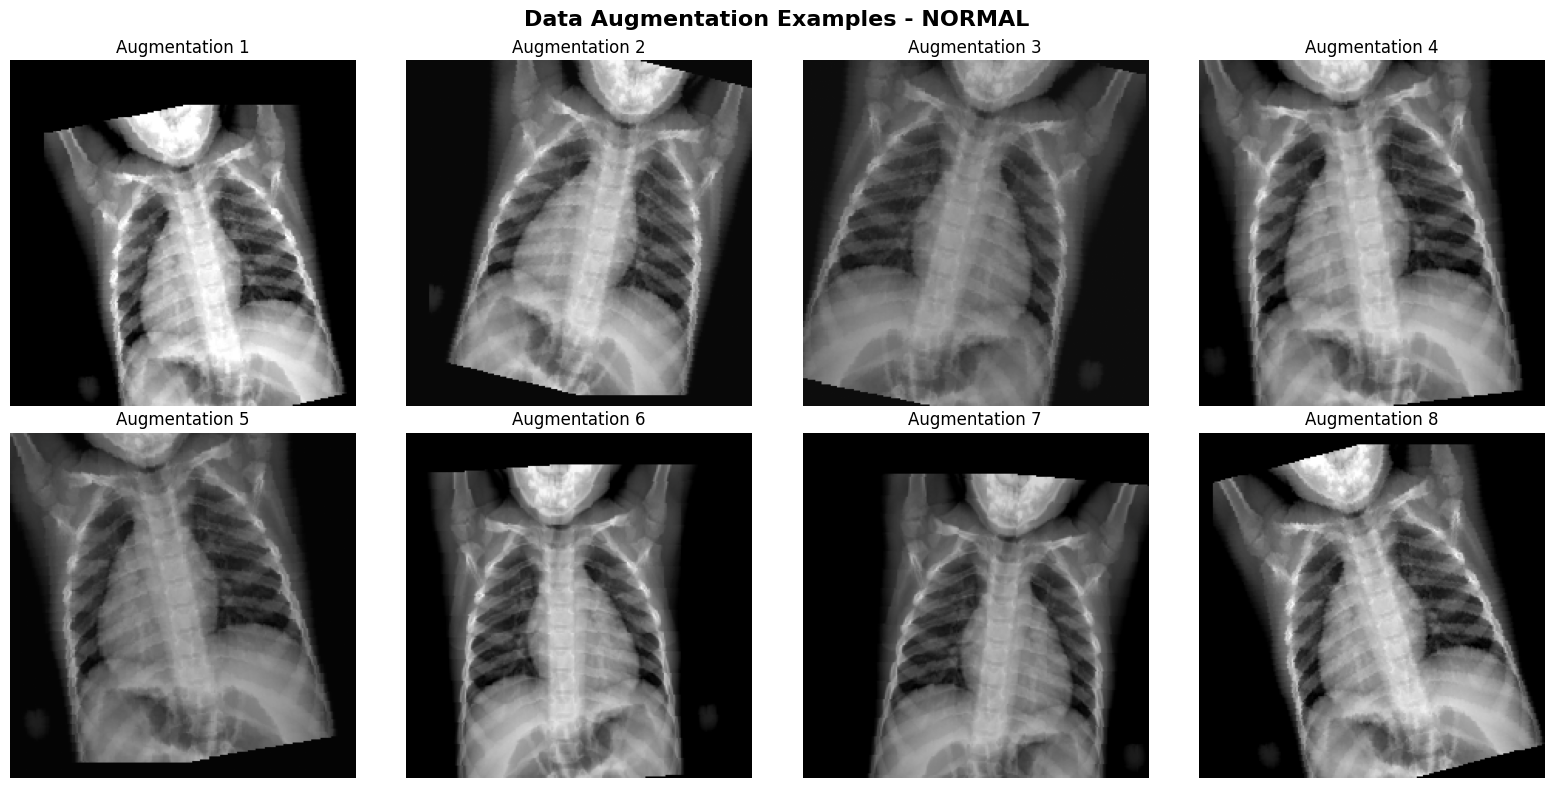

In [29]:
# Create outputs directory first
import os
os.makedirs('outputs', exist_ok=True)

# Then run your visualization code
fig1 = visualize_augmentation(train_dataset, idx=0)  # Normal
plt.savefig('outputs/augmentation_normal.png', dpi=300, bbox_inches='tight')
plt.show()

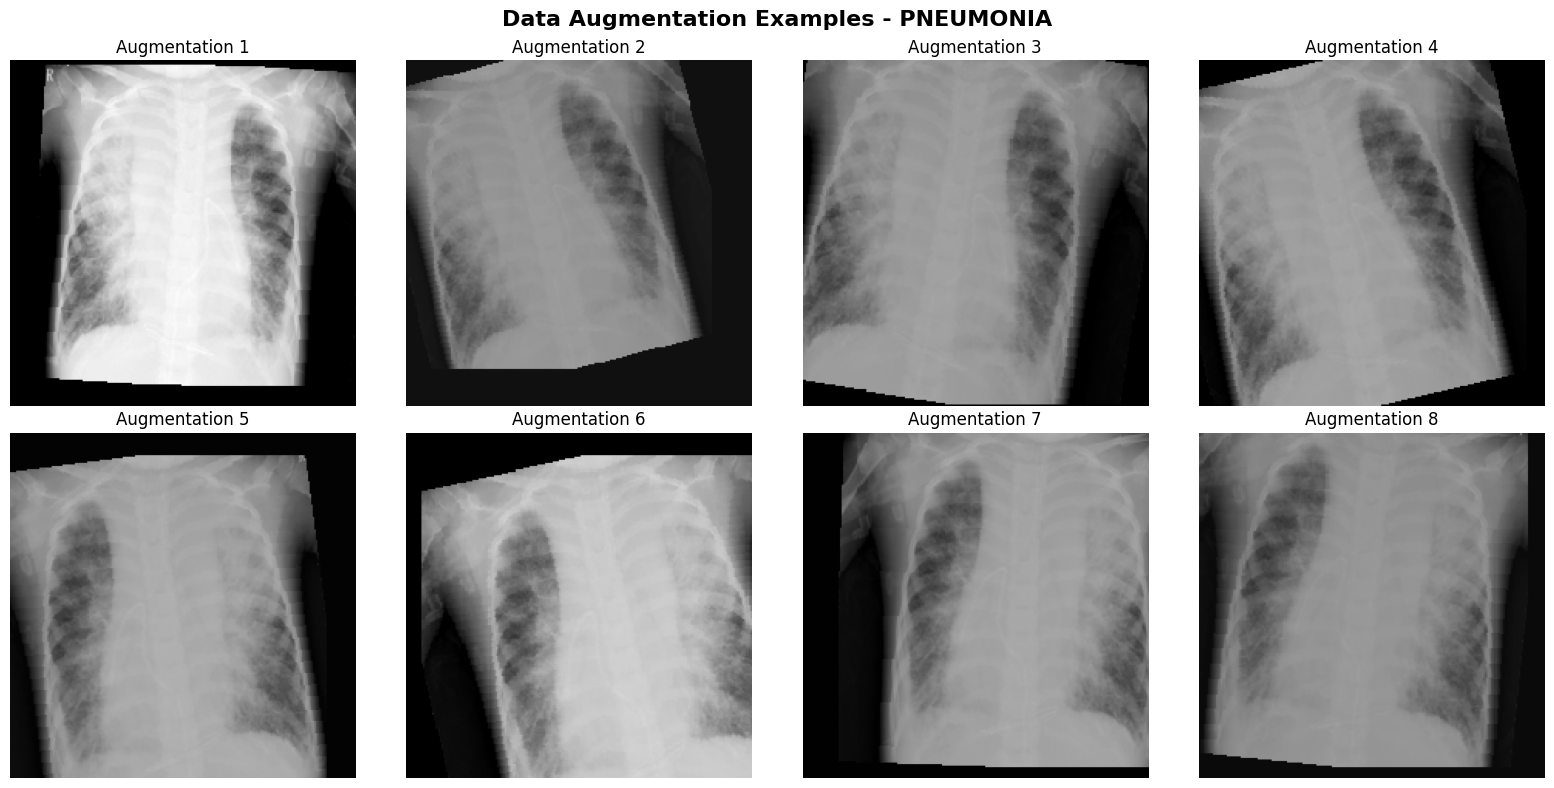


 Augmentation visualizations saved for both classes!

 Augmentation visualizations saved!


In [31]:
# Visualize augmentation effects
def visualize_augmentation(dataset, idx=0, num_augmentations=8):
    """Show how augmentation transforms the same image"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    # Get original image path
    original_img = Image.open(dataset.image_paths[idx]).convert('RGB')
    label = dataset.labels[idx]
    class_name = 'NORMAL' if label == 0 else 'PNEUMONIA'

    fig.suptitle(f'Data Augmentation Examples - {class_name}', fontsize=16, fontweight='bold')

    # Generate multiple augmented versions
    for i in range(num_augmentations):
        img_tensor, _ = dataset[idx]

        # Denormalize for visualization
        img_denorm = img_tensor.clone()
        for t, m, s in zip(img_denorm, IMAGENET_MEAN, IMAGENET_STD):
            t.mul_(s).add_(m)
        img_denorm = torch.clamp(img_denorm, 0, 1)

        # Convert to numpy
        img_np = img_denorm.permute(1, 2, 0).numpy()

        axes[i].imshow(img_np)
        axes[i].axis('off')
        axes[i].set_title(f'Augmentation {i+1}')

    plt.tight_layout()
    return fig

# Find a pneumonia sample - CORRECT VERSION
pneumonia_indices = [i for i in range(len(train_dataset)) if train_dataset.labels[i] == 1]

if pneumonia_indices:
    pneumonia_idx = pneumonia_indices[0]
    fig2 = visualize_augmentation(train_dataset, idx=pneumonia_idx)  # Pneumonia
    plt.savefig('outputs/augmentation_pneumonia.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n Augmentation visualizations saved for both classes!")
else:
    print(" No pneumonia samples found!")

print("\n Augmentation visualizations saved!")

In [32]:
# Set up Stratified K-Fold Cross Validation
print("\nSETTING UP STRATIFIED K-FOLD CROSS VALIDATION")
print("="*50)

N_FOLDS = 5
BATCH_SIZE = 32

#Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

print(f"Stratified {N_FOLDS}-Fold CV configured")
print(f"   - Maintains class distribution in each fold")
print(f"   - Shuffle: True (randomized splits)")
print(f"   - Random seed: 42 (reproducible)")
print(f"\n💡 This means:")
print(f"   - Train on ~4,170 images (80%)")
print(f"   - Validate on ~1,046 images (20%)")
print(f"   - Repeat 5 times with different splits")
print(f"   - Average results across all 5 folds")
print("="*50)


SETTING UP STRATIFIED K-FOLD CROSS VALIDATION
Stratified 5-Fold CV configured
   - Maintains class distribution in each fold
   - Shuffle: True (randomized splits)
   - Random seed: 42 (reproducible)

💡 This means:
   - Train on ~4,170 images (80%)
   - Validate on ~1,046 images (20%)
   - Repeat 5 times with different splits
   - Average results across all 5 folds



 K-Fold Split Statistics:
 Fold  Train Size  Val Size  Train Normal  Train Pneumonia  Val Normal  Val Pneumonia
    1        1044      1044          1072             3100         269            775
    2        1043      1043          1073             3100         268            775
    3        1043      1043          1073             3100         268            775
    4        1043      1043          1073             3100         268            775
    5        1043      1043          1073             3100         268            775


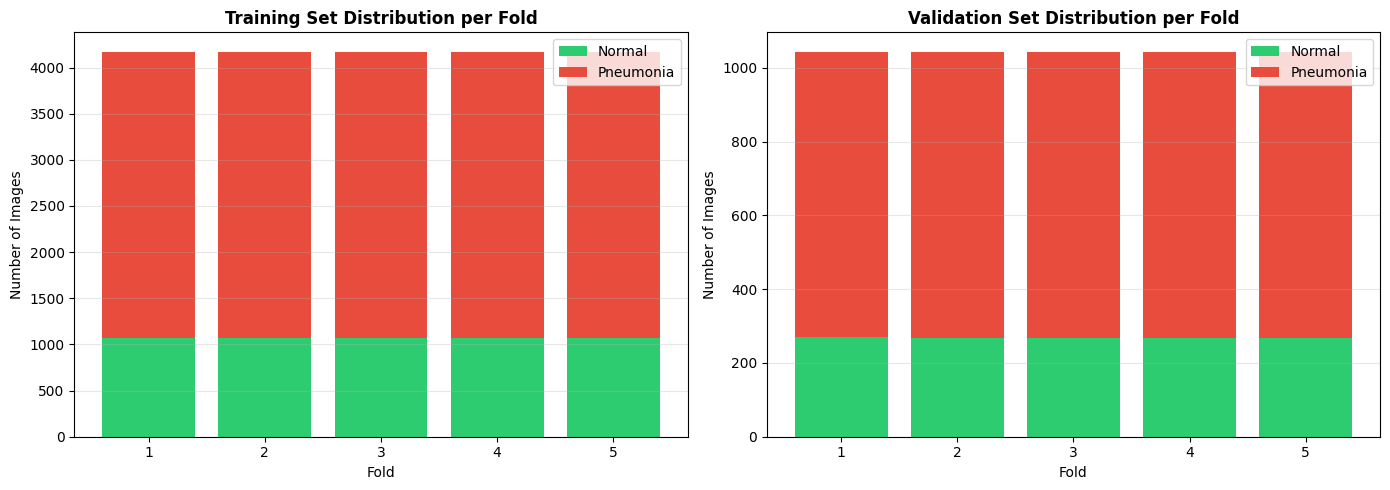


 K-Fold distribution visualizations saved!


In [33]:
# Visualize fold distribution
fold_stats = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_paths, train_labels)):
    train_fold_labels = [train_labels[i] for i in train_idx]
    val_fold_labels = [train_labels[i] for i in val_idx]

    fold_stats.append({
        'Fold': fold + 1,
        'Train Size': len(val_idx),
        'Val Size': len(val_idx),
        'Train Normal': train_fold_labels.count(0),
        'Train Pneumonia': train_fold_labels.count(1),
        'Val Normal': val_fold_labels.count(0),
        'Val Pneumonia': val_fold_labels.count(1)
    })

df_folds = pd.DataFrame(fold_stats)
print("\n K-Fold Split Statistics:")
print(df_folds.to_string(index=False))

# Visualize fold distribution
fig, axes = plt.subplots(1,2, figsize=(14, 5))


# Training set distribution across folds
axes[0].bar(df_folds['Fold'], df_folds['Train Normal'], label='Normal', color='#2ecc71')
axes[0].bar(df_folds['Fold'], df_folds['Train Pneumonia'],
            bottom=df_folds['Train Normal'], label='Pneumonia', color='#e74c3c')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Number of Images')
axes[0].set_title('Training Set Distribution per Fold', fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Validation set distribution across folds
axes[1].bar(df_folds['Fold'], df_folds['Val Normal'], label='Normal', color='#2ecc71')
axes[1].bar(df_folds['Fold'], df_folds['Val Pneumonia'],
            bottom=df_folds['Val Normal'], label='Pneumonia', color='#e74c3c')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Number of Images')
axes[1].set_title('Validation Set Distribution per Fold', fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/kfold_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n K-Fold distribution visualizations saved!")

In [34]:
# Function to create dataloaders for a specific fold
def create_fold_dataloaders(train_idx, val_idx, batch_size=32):
    """
    Create train and validation dataloaders for a specific fold

    Args:
        train_idx: Indices for training set
        val_idx: Indices for validation set
        batch_size: Batch size for dataloaders

    Returns:
        train_loader, val_loader
    """
    # Create datasets
    train_dataset = ChestXRayDataset(
        [train_paths[i] for i in train_idx],
        [train_labels[i] for i in train_idx],
        transform=train_transforms
    )

    val_dataset = ChestXRayDataset(
        [train_paths[i] for i in val_idx],
        [train_labels[i] for i in val_idx],
        transform=val_transforms
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, val_loader

print("\nDataLoader helper function created!")
print("   - Automatically creates train/val loaders for any fold")
print("   - Uses appropriate transforms for each split")
print("   - Optimized with pin_memory for faster GPU transfer")


DataLoader helper function created!
   - Automatically creates train/val loaders for any fold
   - Uses appropriate transforms for each split
   - Optimized with pin_memory for faster GPU transfer


In [35]:
# Test dataloader with first fold
print("\nTESTING DATALOADER")
print("="*50)

# Get first fold
train_idx, val_idx = next(skf.split(train_paths, train_labels))

# Create dataloaders
train_loader, val_loader = create_fold_dataloaders(train_idx, val_idx, batch_size=BATCH_SIZE)

print(f"DataLoaders created for Fold 1:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# Test loading a batch
images, labels = next(iter(train_loader))
print(f"\n Sample batch loaded:")
print(f"   Batch shape: {images.shape}")
print(f"   Labels shape: {labels.shape}")
print(f"   Batch size: {images.shape[0]}")
print(f"   Image dimensions: {images.shape[2]}x{images.shape[3]}")
print(f"   Labels in batch: {labels.tolist()[:10]}...")  # Show first 10
print("="*50)


TESTING DATALOADER
DataLoaders created for Fold 1:
Train batches: 131
Val batches: 33

 Sample batch loaded:
   Batch shape: torch.Size([32, 3, 224, 224])
   Labels shape: torch.Size([32])
   Batch size: 32
   Image dimensions: 224x224
   Labels in batch: [0, 1, 1, 1, 1, 0, 1, 1, 1, 1]...


In [36]:
# Create test dataset and dataloader (separate from K-Fold)
print("\n  CREATING TEST DATALOADER")
print("="*50)

test_dataset = ChestXRayDataset(
    test_paths,
    test_labels,
    transform=val_transforms  # No augmentation for test
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"   Test DataLoader created:")
print(f"   Total images: {len(test_dataset)}")
print(f"   Total batches: {len(test_loader)}")
print(f"   Batch size: {BATCH_SIZE}")
print("\n  Test set will be used for final evaluation only!")
print("   (Not touched during training or validation)")
print("="*50)


  CREATING TEST DATALOADER
   Test DataLoader created:
   Total images: 624
   Total batches: 20
   Batch size: 32

  Test set will be used for final evaluation only!
   (Not touched during training or validation)


In [37]:
# Saving all preprocessing configuration
config = {
    'data_info': {
        'train_size': len(train_paths),
        'test_size': len(test_paths),
        'num_classes': 2,
        'class_names': class_names,
        'class_to_idx': class_to_idx
    },

    'augmentation': {
        'resize': 224,
        'rotation_degrees': 15,
        'horizontal_flip_prob': 0.5,
        'translate': (0.1, 0.1),
        'scale': (0.9, 1.1),
        'brightness': 0.2,
        'contrast': 0.2
    },

    'kfold': {
        'n_folds': N_FOLDS,
        'shuffle': True,
        'random_state': 42
    },

    'training': {
        'batch_size': BATCH_SIZE,
        'num_workers': 2,
        'pin_memory': True
    },
    'class_weights':{
        'normal': float(class_weights[0]),
        'pneumonia': float(class_weights[1]),

    }
}


with open('outputs/preprocessing_config.json', 'w') as f:
    json.dump(config, f, indent=4)

print("\n  Configuration saved to outputs/preprocessing_config.json")
print("\n  PREPROCESSING CONFIGURATION:")
print(json.dumps(config, indent=2))


  Configuration saved to outputs/preprocessing_config.json

  PREPROCESSING CONFIGURATION:
{
  "data_info": {
    "train_size": 5216,
    "test_size": 624,
    "num_classes": 2,
    "class_names": [
      "NORMAL",
      "PNEUMONIA"
    ],
    "class_to_idx": {
      "NORMAL": 0,
      "PNEUMONIA": 1
    }
  },
  "augmentation": {
    "resize": 224,
    "rotation_degrees": 15,
    "horizontal_flip_prob": 0.5,
    "translate": [
      0.1,
      0.1
    ],
    "scale": [
      0.9,
      1.1
    ],
    "brightness": 0.2,
    "contrast": 0.2
  },
  "kfold": {
    "n_folds": 5,
    "shuffle": true,
    "random_state": 42
  },
  "training": {
    "batch_size": 32,
    "num_workers": 2,
    "pin_memory": true
  },
  "class_weights": {
    "normal": 1.9448173005219984,
    "pneumonia": 0.6730322580645162
  }
}


In [39]:
# Generate Day 2 summary report
print("\n" + "="*60)
print("  DAY 2 SUMMARY - DATA PREPROCESSING COMPLETE")
print("="*60)

print("\n  ACCOMPLISHMENTS:")
print("   1. Calculated class weights for imbalanced data")
print(f"      - Normal: {class_weights[0]:.4f}")
print(f"      - Pneumonia: {class_weights[1]:.4f}")

print("\n   2. Defined data transforms:")
print("      - Training: WITH augmentation (rotation, flip, jitter)")
print("      - Validation/Test: WITHOUT augmentation")

print("\n   3. Created custom PyTorch Dataset class")
print("      - Memory-efficient on-the-fly loading")
print("      - Flexible transform application")

print("\n   4. Set up 5-Fold Cross Validation")
print(f"      - {N_FOLDS} folds with stratified splits")
print("      - ~4,170 train / ~1,046 val per fold")

print("\n   5. Built DataLoader pipeline")
print(f"      - Batch size: {BATCH_SIZE}")
print("      - GPU-optimized with pin_memory")

print("\n   6. Created test set loader")
print(f"      - {len(test_dataset)} images")
print("      - Reserved for final evaluation")

print("\n  FILES GENERATED:")
print("   - outputs/class_weights.json")
print("   - outputs/preprocessing_config.json")
print("   - outputs/augmentation_normal.png")
print("   - outputs/augmentation_pneumonia.png")
print("   - outputs/kfold_distribution.png")

print("\n  READY FOR DAY 3:")
print("   - Build baseline model (ResNet50)")
print("   - Set up training loop with class weights")
print("   - Train on Fold 1 as proof of concept")
print("   - Monitor training/validation metrics")

print("\n" + "="*60)
print("  DAY 2 COMPLETE! Great progress!")
print("="*60)

# Save summary report
summary = f"""
# Day 2 Summary - MediScan-AI

**Date:** {pd.Timestamp.now().strftime('%Y-%m-%d')}

## Objectives Completed
   Data preprocessing pipeline built
   Class weights calculated ({class_weights[0]:.4f}, {class_weights[1]:.4f})
   Data augmentation configured
   5-Fold Cross Validation setup
   Custom Dataset and DataLoaders created

## Key Metrics
- Training images: {len(train_paths)}
- Test images: {len(test_paths)}
- Batch size: {BATCH_SIZE}
- K-Folds: {N_FOLDS}

## Augmentation Strategy
- Random rotation (±15°)
- Random horizontal flip (50%)
- Random affine transformation
- Color jitter (brightness & contrast)

## Next Steps (Day 3)
1. Build ResNet50 baseline model
2. Implement training loop with class weights
3. Train first fold as proof of concept
4. Set up metrics tracking

## Status
   Day 2 Complete - Ready for Model Building
"""

with open('outputs/day2_summary.txt', 'w') as f:
    f.write(summary)

print("\n  Summary saved to outputs/day2_summary.txt")


  DAY 2 SUMMARY - DATA PREPROCESSING COMPLETE

  ACCOMPLISHMENTS:
   1. Calculated class weights for imbalanced data
      - Normal: 1.9448
      - Pneumonia: 0.6730

   2. Defined data transforms:
      - Training: WITH augmentation (rotation, flip, jitter)
      - Validation/Test: WITHOUT augmentation

   3. Created custom PyTorch Dataset class
      - Memory-efficient on-the-fly loading
      - Flexible transform application

   4. Set up 5-Fold Cross Validation
      - 5 folds with stratified splits
      - ~4,170 train / ~1,046 val per fold

   5. Built DataLoader pipeline
      - Batch size: 32
      - GPU-optimized with pin_memory

   6. Created test set loader
      - 624 images
      - Reserved for final evaluation

  FILES GENERATED:
   - outputs/class_weights.json
   - outputs/preprocessing_config.json
   - outputs/augmentation_normal.png
   - outputs/augmentation_pneumonia.png
   - outputs/kfold_distribution.png

  READY FOR DAY 3:
   - Build baseline model (ResNet50)
   -

In [40]:
# Zip and download all outputs
!zip -r outputs.zip outputs/

# Download the zip file
from google.colab import files
files.download('outputs.zip')

print("  All outputs downloaded as outputs.zip")

  adding: outputs/ (stored 0%)
  adding: outputs/augmentation_normal.png (deflated 12%)
  adding: outputs/augmentation_pneumonia.png (deflated 13%)
  adding: outputs/preprocessing_config.json (deflated 60%)
  adding: outputs/day2_summary.txt (deflated 36%)
  adding: outputs/kfold_distribution.png (deflated 29%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

  All outputs downloaded as outputs.zip


In [42]:
# Find your current notebook name
import os
current_notebook = [f for f in os.listdir('/content') if f.endswith('.ipynb')]
print("📓 Current notebook files:")
for nb in current_notebook:
    print(f"   - {nb}")

# Your actual filename is probably something like:
# "02_data_preprocessing.ipynb" or with numbers like "Copy_of_02_data_preprocessing.ipynb"


📓 Current notebook files:
